<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/stage_2_decision/No_Shows%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, classification_report, roc_curve
import optuna
from hotel_preprocessing_orig import XYPreprocessor

In [3]:
def load_and_engineer_targets(file_path):
    df = pd.read_csv(file_path)

    # Create arrival_date
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' +
        df['arrival_date_month'] + '-' +
        df['arrival_date_day_of_month'].astype(str),
        format='%Y-%B-%d'
    )
    df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

    # Stage 1 target
    df['is_canceled'] = df['reservation_status'].isin(['Canceled', 'No-Show']).astype(int)

    # Stage 2 target
    df['days_before_arrival'] = (df['arrival_date'] - df['reservation_status_date']).dt.days
    df['late_or_noshow'] = ((df['reservation_status'] == 'No-Show') |
                            ((df['reservation_status'] == 'Canceled') &
                             (df['days_before_arrival'] <= 3))).astype(int)

    return df

In [26]:
def make_objective(X, y):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 2, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
            "ccp_alpha": trial.suggest_float("ccp_alpha", 1e-4, 0.02, log=True),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
        }

        aucs = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = DecisionTreeClassifier(**params, random_state=42, class_weight='balanced')
            model.fit(X_train, y_train)
            y_val_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_val_pred)
            aucs.append(auc)

        return np.mean(aucs)
    return objective

In [30]:
def evaluate_model(model, X_test, y_test, stage_name, feature_names=None):
    y_proba = model.predict_proba(X_test)[:, 1]

    # === 1. Precision-Recall Threshold Tuning ===
    from sklearn.metrics import precision_recall_curve

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Print candidate thresholds with high recall
    print("\nThresholds with Recall ≥ 0.6:")
    for t, p, r in zip(thresholds, precision, recall):
        if r >= 0.6:
            print(f"  Threshold: {t:.3f}, Recall: {r:.3f}, Precision: {p:.3f}")

    # Pick threshold that gives best F1
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"\nBest F1 threshold: {best_threshold:.3f}")

    # Apply custom threshold
    y_pred = (y_proba >= best_threshold).astype(int)

    # === 2. Metrics ===
    from sklearn.metrics import roc_auc_score, recall_score, classification_report, roc_curve

    auc = roc_auc_score(y_test, y_proba)
    recall_score_val = recall_score(y_test, y_pred)

    print(f"\n=== {stage_name} Evaluation ===")
    print("AUC:", auc)
    print("Recall:", recall_score_val)
    print(classification_report(y_test, y_pred))

    # === 3. ROC Curve ===
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{stage_name} - ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === 4. Feature Importances ===
    if hasattr(model, "feature_importances_"):
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(X_test.shape[1])]
        importances = pd.Series(model.feature_importances_, index=feature_names)
        print("\nTop 10 Feature Importances:")
        print(importances.sort_values(ascending=False).head(10))

In [33]:
def run_stage(data, target_col, drop_cols, cutoff_date, stage_name):
    train_data = data[data['arrival_date'] <= cutoff_date]
    test_data = data[data['arrival_date'] > cutoff_date]

    X_train_raw = train_data.drop(columns=drop_cols + [target_col])
    y_train = train_data[target_col]
    X_test_raw = test_data.drop(columns=drop_cols + [target_col])
    y_test = test_data[target_col]

    preprocessor = XYPreprocessor()
    X_train, y_train = preprocessor.fit_transform(X_train_raw, y_train)
    X_test, y_test = preprocessor.transform(X_test_raw, y_test)

    # Only for Stage 2: drop engineered features that leak label
    if stage_name.startswith("Stage 2"):
        for col in ['lead_time_log', 'lead_time', 'arrival_date']:
            if col in X_train.columns:
                X_train.drop(columns=col, inplace=True)
                X_test.drop(columns=col, inplace=True)

    # Optuna tuning
    objective = make_objective(X_train, y_train)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    print(best_params)
    model = DecisionTreeClassifier(**best_params, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    evaluate_model(model, X_test, y_test, stage_name, feature_names=X_train.columns.tolist())

    from sklearn.linear_model import LogisticRegression

    # Train a logistic regression for interpretability
    logit = LogisticRegression(max_iter=1000, class_weight='balanced')
    logit.fit(X_train, y_train)

    coefs = pd.Series(logit.coef_[0], index=X_train.columns)
    print("\nLogistic Regression Coefficients (Top 10 Positive):")
    print(coefs.sort_values(ascending=False).head(10))

    print("\nLogistic Regression Coefficients (Top 10 Negative):")
    print(coefs.sort_values().head(10))

    return model, X_train_raw.columns.tolist()


In [22]:
df = load_and_engineer_targets("hotel_bookings.csv")
cutoff_date = df['arrival_date'].max() - pd.DateOffset(months=3)
print(df.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'days_before_arrival', 'late_or_noshow'],
      dtype='object')


[I 2025-06-20 15:59:55,024] A new study created in memory with name: no-name-a8bd2265-db1c-4f5c-bd31-539b625f6fed
[I 2025-06-20 15:59:58,357] Trial 0 finished with value: 0.8727753715385973 and parameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 17, 'ccp_alpha': 0.0002506180583989942, 'criterion': 'gini'}. Best is trial 0 with value: 0.8727753715385973.
[I 2025-06-20 16:00:03,065] Trial 1 finished with value: 0.8463947370709983 and parameters: {'max_depth': 49, 'min_samples_split': 6, 'min_samples_leaf': 16, 'ccp_alpha': 0.009282833574499856, 'criterion': 'gini'}. Best is trial 0 with value: 0.8727753715385973.
[I 2025-06-20 16:00:07,708] Trial 2 finished with value: 0.8840269927629547 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 20, 'ccp_alpha': 0.0023983559020347546, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8840269927629547.
[I 2025-06-20 16:00:13,621] Trial 3 finished with value: 0.8940782547970153 and parameters: 

{'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 6, 'ccp_alpha': 0.00023404567652069816, 'criterion': 'entropy'}

Thresholds with Recall ≥ 0.6:
  Threshold: 0.000, Recall: 1.000, Precision: 0.352
  Threshold: 0.001, Recall: 0.999, Precision: 0.377
  Threshold: 0.009, Recall: 0.999, Precision: 0.401
  Threshold: 0.010, Recall: 0.999, Precision: 0.412
  Threshold: 0.017, Recall: 0.999, Precision: 0.419
  Threshold: 0.021, Recall: 0.999, Precision: 0.420
  Threshold: 0.025, Recall: 0.998, Precision: 0.423
  Threshold: 0.028, Recall: 0.990, Precision: 0.425
  Threshold: 0.029, Recall: 0.990, Precision: 0.426
  Threshold: 0.040, Recall: 0.990, Precision: 0.428
  Threshold: 0.057, Recall: 0.986, Precision: 0.464
  Threshold: 0.066, Recall: 0.986, Precision: 0.466
  Threshold: 0.074, Recall: 0.986, Precision: 0.470
  Threshold: 0.089, Recall: 0.985, Precision: 0.471
  Threshold: 0.092, Recall: 0.985, Precision: 0.473
  Threshold: 0.110, Recall: 0.984, Precision: 0.476
  Threshold

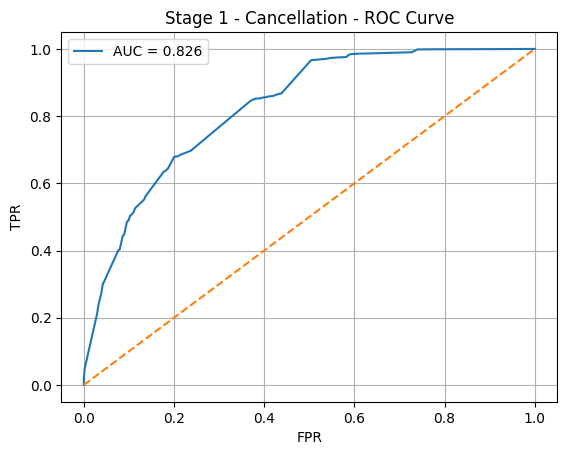


Top 10 Feature Importances:
agent_binned_Other             0.178072
room_type_match                0.132733
required_car_parking_spaces    0.119120
lead_time_log                  0.100963
total_of_special_requests      0.077215
country_binned_PRT             0.076535
market_segment_Online TA       0.051115
arrival_date_year              0.038728
agent_binned_7.0               0.037742
previous_cancellations         0.020751
dtype: float64

Logistic Regression Coefficients (Top 10 Positive):
previous_cancellations            10.324002
lead_time_log                      4.131389
booking_changes                    3.289598
stays_in_week_nights               2.511557
adr                                2.120197
room_type_match                    2.050753
country_binned_PRT                 2.038446
children                           1.742099
distribution_channel_Undefined     1.673164
deposit_type_Non Refund            1.637958
dtype: float64

Logistic Regression Coefficients (Top 10 Negati

In [35]:
stage1_drop_cols = ['late_or_noshow', 'days_before_arrival', 'reservation_status', 'reservation_status_date', 'arrival_date']
model1, feat_names1 = run_stage(df, 'is_canceled', stage1_drop_cols, cutoff_date, stage_name='Stage 1 - Cancellation')

[I 2025-06-20 15:57:57,090] A new study created in memory with name: no-name-24bfa739-b832-495f-b665-324f59b41c7d
[I 2025-06-20 15:57:58,644] Trial 0 finished with value: 0.6759198322963303 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 19, 'ccp_alpha': 0.012887402189644554, 'criterion': 'gini'}. Best is trial 0 with value: 0.6759198322963303.
[I 2025-06-20 15:58:00,300] Trial 1 finished with value: 0.7922755322833421 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 6, 'ccp_alpha': 0.0011424795090413185, 'criterion': 'gini'}. Best is trial 1 with value: 0.7922755322833421.
[I 2025-06-20 15:58:01,809] Trial 2 finished with value: 0.7298610174468251 and parameters: {'max_depth': 26, 'min_samples_split': 11, 'min_samples_leaf': 6, 'ccp_alpha': 0.00010260078660784029, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7922755322833421.
[I 2025-06-20 15:58:03,005] Trial 3 finished with value: 0.7819091561527232 and parameters:

{'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 10, 'ccp_alpha': 0.0006850250921045533, 'criterion': 'gini'}

Thresholds with Recall ≥ 0.6:
  Threshold: 0.037, Recall: 1.000, Precision: 0.064
  Threshold: 0.055, Recall: 0.997, Precision: 0.065
  Threshold: 0.164, Recall: 0.990, Precision: 0.065
  Threshold: 0.187, Recall: 0.986, Precision: 0.064
  Threshold: 0.251, Recall: 0.708, Precision: 0.127
  Threshold: 0.301, Recall: 0.702, Precision: 0.127
  Threshold: 0.403, Recall: 0.702, Precision: 0.128

Best F1 threshold: 0.781

=== Stage 2 - Late Cancel / No-Show Evaluation ===
AUC: 0.7429186816282456
Recall: 0.3152542372881356
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4332
           1       0.55      0.32      0.40       295

    accuracy                           0.94      4627
   macro avg       0.75      0.65      0.68      4627
weighted avg       0.93      0.94      0.93      4627



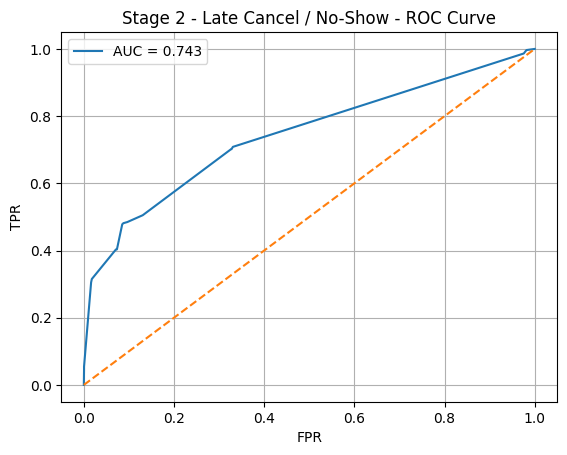


Top 10 Feature Importances:
distribution_channel_TA/TO    0.373523
room_type_match               0.158916
total_guests                  0.059402
country_binned_PRT            0.058416
stays_in_week_nights          0.051000
agent_binned_240.0            0.041796
deposit_type_No Deposit       0.039853
arrival_date_year             0.038652
hotel_Resort Hotel            0.023829
deposit_type_Non Refund       0.021877
dtype: float64

Logistic Regression Coefficients (Top 10 Positive):
deposit_type_Refundable       1.629623
total_of_special_requests     1.280300
agent_binned_Not Specified    1.157547
reserved_room_type_B          1.047638
deposit_type_No Deposit       0.939173
assigned_room_type_F          0.866298
market_segment_Aviation       0.846266
hotel_City Hotel              0.833108
reserved_room_type_C          0.716326
reserved_room_type_P          0.714902
dtype: float64

Logistic Regression Coefficients (Top 10 Negative):
previous_cancellations    -5.178081
total_guests       

In [34]:
stage2_data = df[df['is_canceled'] == 1].copy()
stage2_drop_cols = ['is_canceled', 'days_before_arrival', 'reservation_status', 'reservation_status_date']
model2, feat_names2 = run_stage(stage2_data, 'late_or_noshow', stage2_drop_cols, cutoff_date, stage_name='Stage 2 - Late Cancel / No-Show')